In [ ]:
pip install yfinance

     |████████████████████████████████| 6.3 MB 6.2 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=e4d91a150eb80cd29f45ceeb0880c30509230a92579e4912c156de4f479c4031
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
pip install PyPortfolioOpt

     |████████████████████████████████| 60 kB 3.7 MB/s 
     |████████████████████████████████| 2.7 MB 10.8 MB/s 
  Attempting uninstall: cvxpy
    Found existing installation: cvxpy 1.0.31
    Uninstalling cvxpy-1.0.31:
      Successfully uninstalled cvxpy-1.0.31


## Upload Excel

In [ ]:
import pandas as pd 
import io
from google.colab import files
upload = files.upload()

df = pd.read_excel(io.BytesIO(upload['Portfolio_New.xlsx']))

Saving Portfolio_New.xlsx to Portfolio_New.xlsx


In [ ]:
df

,Ticker,Type,Subtype,Region,Market,Notes,Weight
0,SPY,Public,Large Cap,US,Developed,S&P500,NaN
1,QQQ,Public,Large Cap,US,Developed,NASDAQ100,NaN
2,MCHI,Public,Others,ASIA,Developing,MSCI China,NaN
3,FEZ,Public,Large Cap,EU,Developed,Developed Europe Large Cap,NaN
4,EWN,Public,Others,DUTCH,Developed,Dutch Total Market,NaN
5,EWJ,Public,Others,ASIA,Developed,MSCI Japan,NaN
6,FNDE,Public,Large Cap,EM,Developing,Emerging Large Cap,NaN
7,IGOV,Fixed Income,Sovereign,DM,Developed,"Developed ex US, Treasury",NaN
8,TLT,Fixed Income,Sovereign,US,Developed,US 20yr+ Treasury,NaN
9,LQD,Fixed Income,Investment Grade,US,Developed,US Corporate Investment Grade,NaN


## Import Packages

In [ ]:
import yfinance as yf 
from math import isnan
from pypfopt import EfficientFrontier 
from pypfopt import risk_models 
from pypfopt import expected_returns
from pypfopt.hierarchical_portfolio import HRPOpt
import numpy as np
from numpy.linalg import inv,pinv
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from math import sqrt
from scipy.stats.mstats import gmean
from pypfopt import objective_functions, base_optimizer
import os.path
from os import path
import scipy.optimize as sco


## Optimization definition

In [ ]:
def optimization(Portfolio, rf = 0.02, max_return = False, min_vol = False, manual = False):
  mu = expected_returns.mean_historical_return(Portfolio)
  S = risk_models.sample_cov(Portfolio)
  ef = EfficientFrontier(mu, S)
  if manual == True:
    weight = asset_weight 
    ef.set_weights(weight)
    weight = [asset_weight]

  elif max_return == True:
    weight = ef._max_return(return_value=False)
    weight = [weight]

  elif min_vol == True:
    weight = ef.min_volatility()
    weight = [weight]

  else: 
    weight = ef.max_sharpe()  # Find weights to maximise the Sharpe Ratio.
    weight = [weight]
 
  #perform = ef.portfolio_performance(verbose=True, risk_free_rate = rf)

  result = pd.DataFrame.from_dict(weight)
  result = result.T
  result.columns = ['weight']
  
  
  return result






def max_dd(returns):
    returns = pd.Series(returns)
    r = returns.add(1).cumprod()
    dd = r.div(r.cummax()).sub(1)
    mdd = dd.min()
  
    return mdd






def performance(Portfolio, percentage):

  P_return = Portfolio.pct_change().dropna()

  Portfolio_array = pd.DataFrame.to_numpy(P_return)
  weight_array = percentage
  
  Portfolio_return= np.dot(Portfolio_array , weight_array)




  


  annual_port_vol = np.std(Portfolio_return) * ((252) ** 0.5)
  
  geo_return = gmean(1 + Portfolio_return)-1
  geo_return = ((1 + geo_return) ** 252) -1



   
 #mdd
  m = max_dd(Portfolio_return)
  

  

  X = pd.DataFrame(data = percentage, index =Portfolio.columns, columns = ['weight'] )

  result={}
  result['Expected annual return'] =   geo_return 
  result['Annual volatility'] = annual_port_vol
  result['Max_drawdown'] = m
  result = pd.Series(result)

  cum_return = pd.DataFrame(Portfolio_return, columns=['cumulative_return'])


  # plot
  ((cum_return + 1).cumprod() - 1).plot()
  plt.xlabel('days')
  plt.ylabel('return')
  
  return result

  
  




# Portfolio Method
################################################################################


# return and volatility functions
def Portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights )
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) 
    return std, returns

# volatility function of portfolio
def Portfolio_volatility(weights, mean_returns, cov_matrix):
    return Portfolio_performance(weights, mean_returns, cov_matrix)[0]



def Portfolio_return(weights, mean_returns, cov_matrix, target_return=0, neg=True):
  if neg:
    return -Portfolio_performance(weights, mean_returns, cov_matrix)[1]+target_return
  else:
    if target_return:
      return Portfolio_performance(weights, mean_returns, cov_matrix)[1] - target_return
    return Portfolio_performance(weights, mean_returns, cov_matrix)[1]


# Min Variance model
def MV(mean_returns, cov_matrix, weight_pos_neg='pos'):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    if weight_pos_neg == 'pos':
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    elif weight_pos_neg =='neg':
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) + 1})
    
    result = sco.minimize(Portfolio_volatility, num_assets*[1/num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    

    return result

def MV_return(mean_returns, cov_matrix, target=0, neg=True, weight_pos_neg='pos'):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, target, neg)
    if weight_pos_neg == 'pos':
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    elif weight_pos_neg =='neg':
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) + 1})
    
    
    result = sco.minimize(Portfolio_return, num_assets*[1/num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result                 # weight



# Risk_Parity Model

def risk_parity(Portfolio):
  
  returns = Portfolio.pct_change()
  annual_vol = np.std(Portfolio.pct_change()) * ((252) ** 0.5)
  Total_vol = sum(annual_vol)
  percentage = annual_vol/Total_vol

  return percentage




def set_vol(Portfolio, vol):

  mean_returns = expected_returns.mean_historical_return(Portfolio)
  cov_matrix = risk_models.sample_cov(Portfolio)
  ef = EfficientFrontier(mean_returns, cov_matrix)
  set_ = ef.efficient_risk(vol)
  result_v = pd.DataFrame.from_dict(set_, orient='index', columns = ['weight'])

  return result_v
  

def set_return(Portfolio, r):

  mean_returns = expected_returns.mean_historical_return(Portfolio)
  cov_matrix = risk_models.sample_cov(Portfolio)
  ef = EfficientFrontier(mean_returns, cov_matrix)

  _set_ = ef.efficient_return(r)
  
  result_r = pd.DataFrame.from_dict(_set_, orient='index', columns = ['weight'])

  return result_r

### Portfolio Weights Calculation

#####Check if ticker is available and find its earliest date 

In [ ]:
assets = [i for i in df['Ticker']]

Date_range = []

for i in assets:
  x = yf.Ticker(i)
  hist = x.history(period = 'max')
  hist2 = hist.index[0].date()
  Date_range.append(hist.index[0].date())
  print(i, hist2)
  

    

SPY 1993-01-29
QQQ 1999-03-10
MCHI 2011-03-31
FEZ 2002-10-21
EWN 1996-03-18
EWJ 1996-03-18
FNDE 2013-08-15
IGOV 2009-01-30
TLT 2002-07-30
LQD 2002-07-30
HYXU 2012-04-03
PICB 2010-06-03
USO 2006-04-10
UNG 2007-04-18
GLD 2004-11-18
AMT 1998-02-27
PLD 1997-11-21
WPS 2007-08-07
IFGL 2007-12-27
SCHP 2010-08-05
DBEF 2011-06-09
MNA 2009-11-17
PHDG 2012-12-06
RLY 2012-04-26
PEX 2013-02-28
PSP 2006-10-24
IPO 2013-10-16
SFE 1980-03-17
SIVB 1987-10-26
TNET 2014-03-27


In [ ]:
Start_Date = np.max(Date_range)
Start_Date

datetime.date(2014, 3, 27)

In [ ]:
#df = df[:42]
assets = [i for i in df['Ticker']]

start="2014-03-27" 
end="2021-09-25"
Data = yf.download(assets, interval = '1d', start = start , end = end).dropna() 
Portfolio = Data['Adj Close']


[*********************100%***********************]  30 of 30 completed


##### Check DataFrame

In [ ]:
Portfolio

,AMT,DBEF,EWJ,EWN,FEZ,FNDE,GLD,HYXU,IFGL,IGOV,IPO,LQD,MCHI,MNA,PEX,PHDG,PICB,PLD,PSP,QQQ,RLY,SCHP,SFE,SIVB,SPY,TLT,TNET,UNG,USO,WPS
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-03-27,69.593529,20.970810,40.044598,22.061764,34.006466,21.519674,124.589996,50.483513,20.801891,50.304943,21.058344,92.135773,38.889656,26.268862,21.176323,24.036312,26.366659,32.042679,7.544636,81.426117,24.714125,47.435463,20.284060,125.599998,160.195587,92.459953,19.100000,100.400002,292.000000,25.929333
2014-03-28,70.853058,21.056789,40.473263,22.259817,34.394093,21.637917,124.559998,50.621265,20.956455,50.124752,21.144182,92.064972,39.603642,26.191519,21.530901,24.096792,26.384243,32.378120,7.607929,81.585464,24.790012,47.268864,19.788429,125.989998,160.985336,91.938774,21.309999,100.000000,292.959991,26.066339
2014-03-31,70.628761,21.205296,40.473263,22.492317,34.450630,21.849058,123.610001,50.759026,21.111010,50.134495,21.268166,92.057083,39.656517,26.346210,21.521044,24.304148,26.357855,32.609734,7.690209,82.166534,24.887159,47.303932,20.357485,128.779999,162.304550,91.711800,21.309999,97.680000,292.720001,26.261021
2014-04-01,70.404449,21.353804,40.580433,22.673155,34.797874,22.034864,123.389999,50.836800,21.160192,50.328033,21.697346,91.828117,39.973843,26.433226,21.521044,24.442390,26.384243,32.649670,7.728187,83.609879,24.904049,47.172424,19.907749,129.220001,163.380737,90.928009,21.299999,95.360001,286.640015,26.333134
2014-04-02,70.111145,21.447601,40.937656,22.638706,34.725201,22.068645,124.320000,50.776306,21.349873,49.981884,21.621046,91.701782,40.079624,26.442892,21.521044,24.511507,26.287540,32.593758,7.740846,83.825432,24.980087,47.058434,19.926104,128.500000,163.927521,90.405502,21.010000,97.239998,286.399994,26.563868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-20,289.838165,37.770000,72.370003,51.459999,45.830002,31.299999,164.940002,55.959999,28.403227,52.330002,67.209999,135.779999,66.160004,33.000000,36.333817,35.709999,28.780001,129.059998,15.230000,365.700012,27.901001,63.119999,8.420000,587.630005,434.040009,151.020004,94.919998,17.250000,49.599998,37.591785
2021-09-21,290.515015,38.110001,73.019997,51.910000,46.430000,31.600000,166.039993,55.990002,28.838526,52.290001,68.290001,135.770004,66.839996,32.900002,36.759003,35.740002,28.740000,128.850006,15.410000,366.149994,28.010000,63.029999,8.500000,593.169983,433.630005,150.889999,94.690002,16.870001,49.580002,38.036484
2021-09-22,292.187195,38.439999,72.489998,52.220001,47.009998,32.110001,165.419998,56.000000,29.006710,52.279999,69.080002,136.149994,68.160004,32.939999,37.060001,35.580002,28.690001,130.009995,15.510000,369.570007,28.299999,63.000000,8.550000,607.830017,437.859985,151.789993,95.110001,16.650000,50.480000,38.155067


## Rebalance (Asset Type)

In [ ]:
### set parameters



Dict_Type = {'Public' : 0.4, 'Fixed Income': 0.15, 'Alternative Investment': 0.1, 'REIT': 0.1, "Inflation":0.05, 'Private Equity':0.2}    #first

Pub = []
Fix =[]
Alt = []
Reit = []
Inf = []
Pe = []

Final_asset = {}


# categorize

for i in range(len(df)):
  if df['Type'][i] == 'Public':
    Pub.append(df['Ticker'][i])
  elif df['Type'][i] == 'Fixed Income':
    Fix.append(df['Ticker'][i])
  elif df['Type'][i] == 'Alternative Investment':
    Alt.append(df['Ticker'][i])
  elif df['Type'][i] == 'REIT':
    Reit.append(df['Ticker'][i])
  elif df['Type'][i] == 'Inflation':
    Inf.append(df['Ticker'][i])
  elif df['Type'][i] == 'Private Equity':
    Pe.append(df['Ticker'][i])

Final_asset['Public'] = Pub
Final_asset['Fixed Income'] = Fix
Final_asset['Alternative Investment'] = Alt
Final_asset['REIT'] = Reit
Final_asset['Inflation'] = Inf
Final_asset['Private Equity'] = Pe

#Assign initial weight bar
Ticker_list = {}
for i in assets:
  Ticker_list[i] = (0.01, 0.05)  


# assign Tickers's weight bar manually, otherwise, 1/Total number
#Ticker_list['___'] = (___, 1)







### rebalancing

rebalance = {}
for i in Final_asset:
  if len([Final_asset[i][0]]) > 1:
    rebalance[i] = 1
  else:
    rebalance[i] = Dict_Type[i]

     
Total = sum(rebalance.values())
for i in rebalance:
  rebalance[i] = Total * Dict_Type[i]


### Must get weight first. In this part, we Use Max return.
Bounds = (Ticker_list.values())
bounds = tuple(Bounds)


# Method Selection

mean_returns = np.mean(Portfolio.pct_change())
cov_matrix = risk_models.sample_cov(Portfolio)

# X = MV(mean_returns, cov_matrix)      #min Vol
X = MV_return(mean_returns, cov_matrix)     # max return
percentage = X['x']
result = pd.DataFrame(data = percentage, index =Portfolio.columns, columns = ['weight'] )


initial_weight = result

sub_total_Pub = 0
sub_total_Fix = 0
sub_total_Alt = 0
sub_total_Reit = 0
sub_total_Inf = 0
sub_total_Pe = 0

new_weight ={}

for i in initial_weight.index:
  if i in Final_asset['Public']:
    sub_total_Pub += initial_weight['weight'][i]
  elif i in Final_asset['Fixed Income']:
    sub_total_Fix += initial_weight['weight'][i]
  elif i in Final_asset['Alternative Investment']:
    sub_total_Alt += initial_weight['weight'][i]
  elif i in Final_asset['REIT']:
    sub_total_Reit += initial_weight['weight'][i]
  elif i in Final_asset['Inflation']:
    sub_total_Inf += initial_weight['weight'][i]
  elif i in Final_asset['Private Equity']:
    sub_total_Pe += initial_weight['weight'][i]



for i in initial_weight.index:
  if i in Final_asset['Public']:
    new_weight[i] = (initial_weight['weight'][i]/sub_total_Pub) * rebalance['Public']
  elif i in Final_asset['Fixed Income']:
    new_weight[i] = (initial_weight['weight'][i]/sub_total_Fix) * rebalance['Fixed Income']
  elif i in Final_asset['Alternative Investment']:
    new_weight[i] = (initial_weight['weight'][i]/sub_total_Alt) * rebalance['Alternative Investment']
  elif i in Final_asset['REIT']:
    new_weight[i] = (initial_weight['weight'][i]/sub_total_Reit) * rebalance['REIT']
  elif i in Final_asset['Inflation']:
    new_weight[i] = (initial_weight['weight'][i]/sub_total_Inf) * rebalance['Inflation']
  elif i in Final_asset['Private Equity']:
    new_weight[i] = (initial_weight['weight'][i]/sub_total_Pe) * rebalance['Private Equity']


for i in new_weight:
  if isnan(new_weight[i]) == True:
    new_weight[i] = 0


Total_weight = sum(new_weight.values())


for i in new_weight:
  new_weight[i] = new_weight[i]/Total_weight


new_weight_final = pd.DataFrame.from_dict(new_weight, orient='index', columns = ['weight'] )


## Rebalance (Asset Rigion)

In [ ]:
Dict_Region = {'US':0.3, "ASIA":0.2, "EU":0.2, "DUTCH": 0.2, 'EM':0.1}


Us = []
Asia =[]
Eu = []
Dutch = []
Em = []


Final_asset_region = {}





# categorize

for i in range(len(df)):
  if df['Type'][i] == 'Public':

    if df['Region'][i] == 'US':
      Us.append(df['Ticker'][i])
    elif df['Region'][i] == 'ASIA':
      Asia.append(df['Ticker'][i])
    elif df['Region'][i] == 'EU':
      Eu.append(df['Ticker'][i])
    elif df['Region'][i] == 'DUTCH':
      Dutch.append(df['Ticker'][i])
    elif df['Region'][i] == 'EM':
      Em.append(df['Ticker'][i])


Final_asset_region['US'] = Us
Final_asset_region['ASIA'] = Asia
Final_asset_region[ 'EU'] = Eu
Final_asset_region['DUTCH'] = Dutch
Final_asset_region['EM'] = Em


### rebalancing
rebalance = {}
for i in Final_asset_region:
  if len([Final_asset_region[i][0]]) > 1:
    rebalance[i] = 1
  else:
    rebalance[i] = Dict_Region[i] 
Total = sum(rebalance.values())


for i in rebalance:
  rebalance[i] = Total * Dict_Region[i]


  
# We've get the weight from previous filter

region_weight = {}

for i in Final_asset_region.values():
  for name in i:
    region_weight[name] = new_weight_final['weight'][name]

 


initial_weight = region_weight



sub_total_Us = 0
sub_total_Asia = 0
sub_total_Eu = 0
sub_total_Dutch = 0
sub_total_Em = 0

new_weight ={}


for i in initial_weight:
  
  if i in Final_asset_region['US']:
    sub_total_Us += initial_weight[i]
  elif i in Final_asset_region['ASIA']:
    sub_total_Asia += initial_weight[i]
  elif i in Final_asset_region['EU']:
    sub_total_Eu += initial_weight[i]
  elif i in Final_asset_region['DUTCH']:
    sub_total_Dutch += initial_weight[i]
  elif i in Final_asset_region['EM']:
    sub_total_Em += initial_weight[i]
  







for i in initial_weight:
  
  if i in Final_asset_region['US']:
    new_weight[i] = (initial_weight[i]/sub_total_Us) * rebalance['US']
  elif i in Final_asset_region['ASIA']:
    new_weight[i] = (initial_weight[i]/sub_total_Asia) * rebalance['ASIA']
  elif i in Final_asset_region['EU']:
    new_weight[i] = (initial_weight[i]/sub_total_Eu) * rebalance['EU']
  elif i in Final_asset_region['DUTCH']:
    new_weight[i] = (initial_weight[i]/sub_total_Dutch) * rebalance['DUTCH']
  elif i in Final_asset_region['EM']:    
    new_weight[i] = (initial_weight[i]/sub_total_Em) * rebalance['EM']



for i in new_weight:
  if isnan(new_weight[i]) == True:
    new_weight[i] = 0



Total_weight = sum(new_weight.values())


for i in new_weight:
  new_weight[i] = new_weight[i]/Total_weight


new_weight_final_region = pd.DataFrame.from_dict(new_weight, orient='index', columns = ['weight'] )
new_weight_final_region = new_weight_final_region * Dict_Type['Public']



## Rebalance (Asset Subtype)

In [ ]:
Dict_Subtype = {'Sovereign': 0.5, 'High Yield':0.2, 'Investment Grade':0.3}


Sov = []
Hy =[]
Ig = []



Final_asset_sub = {}





# categorize

for i in range(len(df)):
  if df['Type'][i] == 'Fixed Income':

    if df['Subtype'][i] == 'Sovereign':
      Sov.append(df['Ticker'][i])
    elif df['Subtype'][i] == 'High Yield':
      Hy.append(df['Ticker'][i])
    elif df['Subtype'][i] == 'Investment Grade':
      Ig.append(df['Ticker'][i])
 


Final_asset_sub['Sovereign'] = Sov
Final_asset_sub['High Yield'] = Hy
Final_asset_sub['Investment Grade'] = Ig


Final_asset_sub






### rebalancing
rebalance = {}
for i in Final_asset_sub:
  if len([Final_asset_sub[i][0]]) > 1:
    rebalance[i] = 1
  else:
    rebalance[i] = Dict_Subtype[i] 
Total = sum(rebalance.values())


for i in rebalance:
  rebalance[i] = Total * Dict_Subtype[i]

rebalance




# We've get the weight from previous filter

sub_weight = {}

for i in Final_asset_sub.values():
  for name in i:
    sub_weight[name] = new_weight_final['weight'][name]






initial_weight = sub_weight

sub_total_Sov = 0
sub_total_Hy= 0
sub_total_Ig = 0

new_weight ={}


for i in initial_weight:
  
  if i in Final_asset_sub['Sovereign']:
    sub_total_Sov += initial_weight[i]
  elif i in Final_asset_sub['High Yield']:
    sub_total_Hy += initial_weight[i]
  elif i in Final_asset_sub['Investment Grade']:
    sub_total_Ig += initial_weight[i]
  


for i in initial_weight:
  
  if i in Final_asset_sub['Sovereign']:
    new_weight[i] = (initial_weight[i]/sub_total_Sov) * rebalance['Sovereign']
  elif i in Final_asset_sub['High Yield']:
    new_weight[i] = (initial_weight[i]/sub_total_Hy) * rebalance['High Yield']
  elif i in Final_asset_sub['Investment Grade']:
    new_weight[i] = (initial_weight[i]/sub_total_Ig) * rebalance['Investment Grade']
  
for i in new_weight:
  if isnan(new_weight[i]) == True:
    new_weight[i] = 0


Total_weight = sum(new_weight.values())

for i in new_weight:
  new_weight[i] = new_weight[i]/Total_weight



new_weight_final_sub = pd.DataFrame.from_dict(new_weight, orient='index', columns = ['weight'] )
new_weight_final_sub= new_weight_final_sub * Dict_Type['Fixed Income']



In [ ]:
P_I = pd.concat([new_weight_final_sub, new_weight_final_region])['weight']
target = P_I.index


Portfolio_weight = new_weight_final
for i in Portfolio_weight['weight'].index:
  if i in target:
    Portfolio_weight['weight'][i] = P_I[i]



  

In [ ]:
#########################

## Performance Comparison 


#### Fix volatility and Fix return 

Expected annual return    0.076924
Annual volatility         0.021939
Max_drawdown             -0.005582
dtype: float64

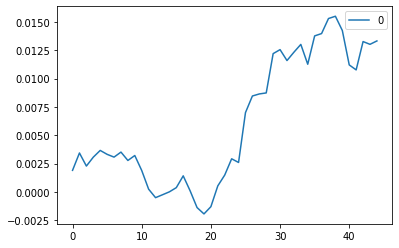

In [ ]:
SR =  set_return(Portfolio, r = 0.10)        # fix return
Fr =  performance(Portfolio, SR['weight'])
Fr

#### Mean-Variance Optimization (Efficient Frontier): Max_return/ Min_Vol/ Max_sharpe ratio

### Risk Parity Allocation

Expected annual return    0.095591
Annual volatility         0.105138
Max_drawdown             -0.034124
dtype: float64

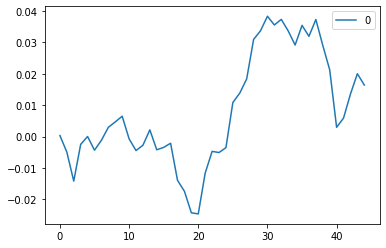

In [ ]:
p = risk_parity(Portfolio)

rp = performance(Portfolio, p)
rp

#### Adjusted weighted Allocation

In [ ]:
Portfolio_weight['weight']

AMT     7.093326e-02
DBEF    0.000000e+00
EWJ     3.364666e-02
EWN     8.000000e-02
FEZ     8.000000e-02
FNDE    4.000000e-02
GLD     0.000000e+00
HYXU             NaN
IFGL    0.000000e+00
IGOV             NaN
IPO     2.996689e-02
LQD              NaN
MCHI    4.635334e-02
MNA     0.000000e+00
PEX     1.807315e-17
PHDG    0.000000e+00
PICB             NaN
PLD     7.192388e-02
PSP     3.911955e-17
QQQ     1.200000e-01
RLY     0.000000e+00
SCHP    0.000000e+00
SFE     0.000000e+00
SIVB    1.238925e-01
SPY     8.110569e-17
TLT              NaN
TNET    1.318549e-01
UNG     0.000000e+00
USO     0.000000e+00
WPS     1.495377e-17
Name: weight, dtype: float64

Expected annual return    0.099580
Annual volatility         0.124244
Max_drawdown             -0.268796
dtype: float64

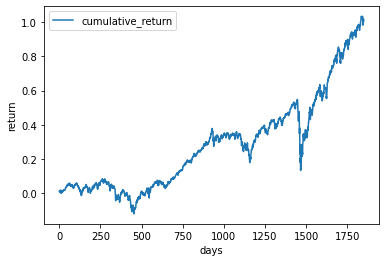

In [ ]:

Ap = performance(Portfolio, Portfolio_weight['weight'])
Ap

### Random weight + fix return (This is testing Only)

In [ ]:
### Random scatter

In [ ]:
df_sort = df.sort_values(by = ['Ticker'])
df_sort = df_sort.reset_index()

In [ ]:
Public = []    
Fixed = []    
Reit=[]     
Alt=[]
Pe = []
Inf = []


for i in range(len(ticker)):
    if df_sort['Type'][i] == 'Public':
        Public.append(i)
    elif df_sort['Type'][i] == 'Fixed Income':
        Fixed.append(i)
    elif df_sort['Type'][i] == 'Alternative Investment':
        Alt.append(i)
    elif df_sort['Type'][i] == 'Private Equity':
        PE.append(i)
    elif df_sort['Type'][i] == 'Inflation':
        Inf.append(i)
    elif df_sort['Type'][i] == 'REIT':
        Reit.append(i)



us = []
asia = []
eu = []
dutch=[]
em = []


for i in range(len(ticker)):
    if df_sort['Region'][i] == 'US':
        us.append(i)
    elif df_sort['Region'][i] == 'ASIA':
        asia.append(i)
    elif df_sort['Region'][i] == 'EU':
        eu.append(i)
    elif df_sort['Region'][i] == 'DUTCH':
        dutch.append(i)
    elif df_sort['Region'][i] == 'EM':
        em.append(i)


sov = []
hy = []
ig = []
for i in range(len(ticker)):
    if df_sort['Subtype'][i] == 'Sovereign':
        sov.append(i)
    elif df_sort['Subtype'][i] == 'High Yield':
        hy.append(i)
    elif df_sort['Subtype'][i] == 'Investment Grad':
        ig.append(i)



In [ ]:
def random_trial(Portfolio, assets_num):
    a = np.random.random(len(Portfolio.columns))
    P_return = Portfolio.pct_change().dropna()
    Portfolio_return= np.dot(P_return , a)

    risk = np.std(Portfolio_return) * ((252) ** 0.5)
    geo_return = gmean(1 + Portfolio_return)-1
    annual_return = ((1 + geo_return) ** 252) -1

    return a, risk, annual_return


weight, risk, annual_return = random_trial(Portfolio, len(Portfolio.columns) )
weight[0]

0.5086470105774659

In [ ]:
lag

NameError: ignored

In [ ]:
N = len(Portfolio.columns) 


comb=np.zeros(1)
comb[0] = 0
min = 0.01
times = 1000000


Log = {}


for i in range(times):
  p_p = 0
  fix_p = 0
  alt_p = 0
  pe_p = 0
  reit_p = 0
  inf_p = 0

  
  weight, risk, annual_return = random_trial(Portfolio, N)
  
  for i in Public:
        p_p += weight[i]

        if p_p not in np.arange (0.49, 0.51):

          continue

        else:
          for i in Fixed:
              fix_p += weight[i]
          if fix_p not in np.arange(0.14, 0.16):
                continue
          else:
            for i in Reit:
              reit_p += weight[i]
            if reit_p not in np.arange(0.09, 0.11):
              continue
            else:
              for i in Alt:
                alt_p += weight[i]
              if alt_p not in np.arange(0.09, 0.11):
                continue
              else:
                for i in Pe:
                  pe_p += weight[i]
                if pe_p not in np.arange(0.09, 0.11):
                  continue
                else:
                  for i in Inf:
                    inf_p += a[0][i]
                  if inf_p not in range(0.09, 0.11): 
                    continue
                  else: 
                    Log[str(annual_return)] = [risk, weight]
                    performance = pd.DataFrame()
                    performance['Annual Volatility'] = risk
                    performance['Annual_return'] = annual_return
                    weightstore = weight
                    print(performance)
                    print(weightstore)

              


              






      




 

    

     


  
    


 
    

   


In [ ]:
Dict_Type = {'Public' : 0.5, 'Fixed Income': 0.15, 'Alternative Investment': 0.1, 'REIT': 0.1, "Inflation":0.05, 'Private Equity':0.1}    #first

In [ ]:
Dict_Region = {'US':0.3, "ASIA":0.2, "EU":0.2, "DUTCH": 0.2, 'EM':0.1}

In [ ]:
Dict_Subtype = {'Sovereign': 0.5, 'High Yield':0.2, 'Investment Grade':0.3}

### Export to CSV


In [ ]:

Final_output2 = pd.DataFrame(index = Portfolio_weight.sort_index()['weight'].index)
Final_output2['Fix volatility'] = SV.sort_index()['weight']
Final_output2['Fix return'] = SR.sort_index()['weight']
Final_output2['Risk Parity'] = p.sort_index()
Final_output2['Mean_variance'] = result.sort_index()['weight']
Final_output2['Adjusted Allocation'] = Portfolio_weight.sort_index()['weight']


In [ ]:
df2 = df.sort_values(by = ['Ticker'])
df2 = df2.set_index('Ticker')

In [ ]:
Output = pd.concat([df2, Final_output2], axis=1)

In [ ]:
Output

,Type,Subtype,Region,Market,Notes,Weight,Fix volatility,Fix return,Risk Parity,Mean_variance,Adjusted Allocation
Ticker,,,,,,,,,,,
AAXJ,Public,Others,ASIA,Developing,MSCI Asia ex Japan,NaN,5.660320e-11,0.000000,0.032183,6.630000e-13,0.011111
AGOV,Fixed Income,Sovereign,ASIA,NaN,Asia Pacific Treasury,NaN,7.407750e-11,0.000000,0.006064,7.034000e-13,0.025000
AMT,REIT,NaN,US,NaN,Cell Tower,NaN,8.063210e-11,0.000000,0.028168,7.063000e-13,0.008891
CCI,REIT,NaN,US,NaN,Cell Tower,NaN,6.877270e-11,0.000000,0.026114,6.722000e-13,0.008891
DBEF,Alternative Investment,Hedge Fund,NaN,NaN,MSCI EAFE,NaN,8.019480e-11,0.000000,0.014941,7.308000e-13,0.012059
DIA,Public,Large Cap,US,Developed,DJI,NaN,6.840020e-11,0.000000,0.016620,7.069000e-13,0.011079
EQIX,REIT,NaN,US,NaN,Data Center,NaN,1.007059e-10,0.003737,0.046476,7.255000e-13,0.043143
EWJ,Public,Others,ASIA,Developed,MSCI Japan,NaN,9.997650e-11,0.000000,0.022607,8.253000e-13,0.055556
EWN,Public,Others,DUTCH,Developed,Dutch Total Market,0.2,9.723920e-11,0.000000,0.022285,8.103000e-13,0.100000


In [ ]:
from google.colab import files
Output.to_csv('result.csv') 
files.download('result.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>